#### Vivian Xia

# Forecasting Netflix Stock Prices with LSTM

## Import packages

In [ ]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.4 MB 6.2 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
import os
import datetime
from packaging import version
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, LSTM, Input, Dropout, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)

In [ ]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.8.0


In [ ]:
print("Keras version: ", keras.__version__)

Keras version:  2.8.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Colab Notebooks/MSDS498/')

Mounted at /content/drive


## Functions

In [ ]:
def datetime_obj(date_time_str):
  date_time_obj = datetime.datetime.strptime(date_time_str, '%Y-%m-%dT%H:%M:%S.%fZ')
  return date_time_obj.date()

In [ ]:
def plot_graphs():
  losses = history.history['loss']
  mae = history.history['mae']
  val_losses = history.history['val_loss']
  val_mae = history.history['val_mae']
  epochs = len(losses)

  plt.figure(figsize=(16, 4))
  for i, metrics in enumerate(zip([losses, mae], [val_losses, val_mae], ['Loss', 'MAE'])):
      plt.subplot(1, 2, i + 1)
      plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
      plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
      plt.legend()
  plt.show()

In [ ]:
def create_dataset(dataset, time_step=1):
  dataX, dataY = [], []
  for i in range(len(dataset)-time_step-1):
    a = dataset[i:(i+time_step), 0] #value at i,i+1,i+2,..i+29
    dataX.append(a) #append list of values at those 30 steps each time used as inputs
    dataY.append(dataset[i + time_step, 0]) #append 30th value as predicted value 
  return np.array(dataX), np.array(dataY)

In [ ]:
def input_sequence(dataset, input1, input2):
  # define input sequence
  in_seq1 = np.array(dataset[input1])
  in_seq2 = np.array(dataset[input2])
  out_seq = np.array(dataset[input1])

  # convert to [rows, columns] structure
  in_seq1 = in_seq1.reshape((len(in_seq1), 1))
  in_seq2 = in_seq2.reshape((len(in_seq2), 1))
  out_seq = out_seq.reshape((len(out_seq), 1))

  return in_seq1, in_seq2, out_seq

# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix, -1]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

## Load Stock Data

In [ ]:
snp = "NFLX" 

# last two years
start_date = datetime.datetime(2020, 4, 22)
end_date = datetime.datetime(2022, 4, 22)

# get the data
df_stock = yf.download(snp, start = start_date, end = end_date)
df_stock.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-04-22,429.730011,433.000000,413.000000,421.420013,421.420013,21084800
2020-04-23,419.260010,438.410004,419.260010,426.700012,426.700012,13952300
2020-04-24,425.000000,427.170013,415.880005,424.989990,424.989990,8658900
2020-04-27,425.000000,429.000000,420.839996,421.380005,421.380005,6277500
2020-04-28,419.989990,421.000000,402.910004,403.829987,403.829987,10101200


In [ ]:
df_stock = df_stock['Close']
df_stock = pd.DataFrame(df_stock)
df_stock.head()

,Close
Date,
2020-04-22,421.420013
2020-04-23,426.700012
2020-04-24,424.989990
2020-04-27,421.380005
2020-04-28,403.829987


### Explore Data

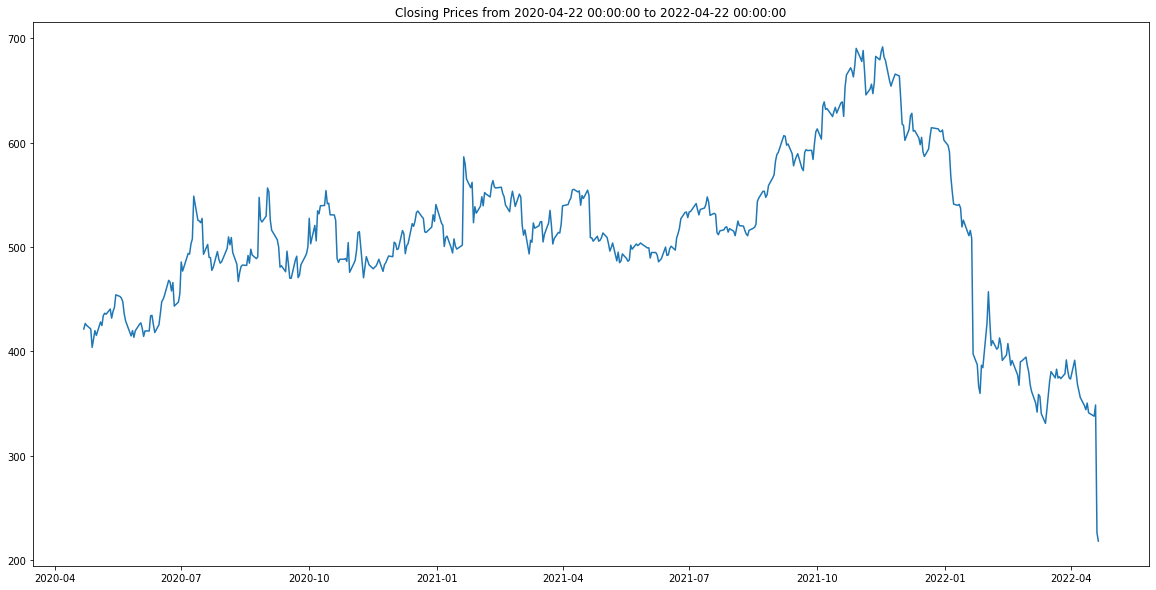

In [ ]:
# display
plt.figure(figsize = (20,10))
plt.title('Closing Prices from {} to {}'.format(start_date, end_date))
plt.plot(df_stock['Close'])
plt.show()

In [ ]:
df_stock.describe()

,Close
count,505.000000
mean,508.478316
std,77.444435
min,218.220001
25%,480.450012
50%,509.079987
75%,547.580017
max,691.690002


## Load Tweet Data

In [ ]:
df_tweet = pd.read_csv("df_full_finbert_sentiment.csv", lineterminator='\n')

In [ ]:
df_tweet.head()

,date,id,text,fine-tuned_finbert_sentiment,finbert
0,2022-04-21T23:59:46.000Z,1.517292e+18,Twitters Thoughts UAL Very Positive IIIN V...,0,1
1,2022-04-21T23:59:04.000Z,1.517292e+18,GPRO NFLX PTON NEW ARTICLE Peloton Netflixs E...,0,1
2,2022-04-21T23:57:16.000Z,1.517291e+18,JOIN ME TONIGHT OCGN ATER NILE SPY QQQ NFLX SN...,0,1
3,2022-04-21T23:57:06.000Z,1.517291e+18,SPX is this start of rally chart decreasing to...,0,1
4,2022-04-21T23:56:58.000Z,1.517291e+18,NFLX 100 stock star,0,1


In [ ]:
df_tweet = df_tweet[['date','fine-tuned_finbert_sentiment','finbert']]
df_tweet = pd.DataFrame(df_tweet)
df_tweet.head()

,date,fine-tuned_finbert_sentiment,finbert
0,2022-04-21T23:59:46.000Z,0,1
1,2022-04-21T23:59:04.000Z,0,1
2,2022-04-21T23:57:16.000Z,0,1
3,2022-04-21T23:57:06.000Z,0,1
4,2022-04-21T23:56:58.000Z,0,1


In [ ]:
df_tweet['date'] = df_tweet['date'].apply(datetime_obj)

In [ ]:
df_tweet.head()

,date,fine-tuned_finbert_sentiment,finbert
0,2022-04-21,0,1
1,2022-04-21,0,1
2,2022-04-21,0,1
3,2022-04-21,0,1
4,2022-04-21,0,1


In [ ]:
df_tweet['fine-tuned_finbert_sentiment'].unique()

array([0])

All tweets were given a sentiment of 0 (positive). There is no value in using the fine-tune FinBert sentiment. 

In [ ]:
df_tweet['finbert'].unique()

array([1, 2, 0])

In [ ]:
df_tweet_avg_sentiment = df_tweet.groupby(['date']).mean()
df_tweet_avg_sentiment.head()

,fine-tuned_finbert_sentiment,finbert
date,,
2020-04-22,0.0,0.859364
2020-04-23,0.0,0.898470
2020-04-24,0.0,0.914110
2020-04-25,0.0,0.873518
2020-04-26,0.0,0.906810


#Experiment A: Input - Closing Price, Time step - 30

## Preprocess Data

In [ ]:
close_scaler = MinMaxScaler(feature_range=(0,1))
data = close_scaler.fit_transform(np.array(df_stock).reshape(-1,1))

In [ ]:
data.shape

(505, 1)

In [ ]:
# split into train, val, and test sets
train_size = int(len(data) * 0.70)
val_size = int(0.18 * len(data))
test_size = len(data) - train_size - val_size

In [ ]:
train_data,val_data, test_data = data[0:train_size,:], data[train_size:train_size+val_size,:], data[train_size+val_size:len(data),:]
train_data.shape, val_data.shape, test_data.shape

((353, 1), (90, 1), (62, 1))

In [ ]:
#reshape into X=t,t+1,...,t+29 and Y=t+30 -- 30 time steps to use as input variables to predict the next time period
time_step = 30
X_train, y_train = create_dataset(train_data, time_step)
X_val, y_val = create_dataset(val_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [ ]:
#reshape input to be [samples, time steps, features] -- only one feature, closing price
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

print("training set: ", X_train.shape)
print("validation set: ", X_val.shape)
print("test set: ", X_test.shape)

training set:  (322, 30, 1)
validation set:  (59, 30, 1)
test set:  (31, 30, 1)


## Experiment A.1

### Create the model

In [ ]:
model = models.Sequential()
model.add(LSTM(30, input_shape=(30, 1), return_sequences=True)) 
model.add(Dropout(0.3))
model.add(LSTM(30))
model.add(Dropout(0.3))
model.add(Dense(1, activation="relu", name="output_layer"))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 30)            3840      
                                                                 
 dropout (Dropout)           (None, 30, 30)            0         
                                                                 
 lstm_1 (LSTM)               (None, 30)                7320      
                                                                 
 dropout_1 (Dropout)         (None, 30)                0         
                                                                 
 output_layer (Dense)        (None, 1)                 31        
                                                                 
Total params: 11,191
Trainable params: 11,191
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss='mean_squared_error',optimizer='adam',metrics=['mae'])

In [ ]:
experiment = "ExperimentA1"
callbacks = [EarlyStopping(monitor='val_mae', patience=3)
            ,ModelCheckpoint("/content/drive/My Drive/Colab Notebooks/MSDS498/LSTM_Models/"+experiment+".h5"
            ,save_best_only=True)]

In [ ]:
%%time
history = model.fit(X_train, y_train,
                    batch_size=16,
                    epochs=50,
                    validation_data=(X_val, y_val),
                    callbacks=callbacks)

Epoch 1/50
21/21 [==============================] - 8s 46ms/step - loss: 0.0808 - mae: 0.2245 - val_loss: 0.0320 - val_mae: 0.1576
Epoch 2/50
21/21 [==============================] - 0s 9ms/step - loss: 0.0185 - mae: 0.1104 - val_loss: 0.0106 - val_mae: 0.0868
Epoch 3/50
21/21 [==============================] - 0s 10ms/step - loss: 0.0147 - mae: 0.0992 - val_loss: 0.0071 - val_mae: 0.0696
Epoch 4/50
21/21 [==============================] - 0s 7ms/step - loss: 0.0142 - mae: 0.0962 - val_loss: 0.0074 - val_mae: 0.0713
Epoch 5/50
21/21 [==============================] - 0s 7ms/step - loss: 0.0110 - mae: 0.0830 - val_loss: 0.0099 - val_mae: 0.0843
Epoch 6/50
21/21 [==============================] - 0s 7ms/step - loss: 0.0127 - mae: 0.0917 - val_loss: 0.0169 - val_mae: 0.1123
CPU times: user 5.93 s, sys: 489 ms, total: 6.42 s
Wall time: 8.89 s


In [ ]:
experiment = "ExperimentA1"
model = tf.keras.models.load_model('/content/drive/My Drive/Colab Notebooks/MSDS498/LSTM_Models/'+experiment+'.h5')

In [ ]:
loss, mae = model.evaluate(X_test, y_test)
print('test set mae: ', mae)

1/1 [==============================] - 1s 679ms/step - loss: 0.0235 - mae: 0.1388
test set mae:  0.1388440579175949


### Plot performance

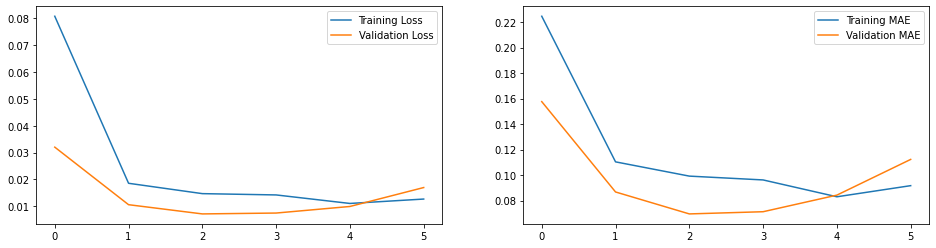

In [ ]:
plot_graphs()

In [ ]:
test_predict = model.predict(X_test)
test_predict = close_scaler.inverse_transform(test_predict)

In [ ]:
vis = close_scaler.inverse_transform(data)
vis = vis[train_size+val_size+time_step:len(data)]

In [ ]:
df1 = df_stock.index.values
df1 = df1[train_size+val_size+time_step:]

In [ ]:
a = pd.DataFrame(df1, columns = ['Date'])
b = pd.DataFrame(vis, columns = ['Actual'])
c = pd.DataFrame(test_predict, columns = ['Predicted'])

In [ ]:
vis_df_a1 = pd.concat([a,b,c], axis=1)
vis_df_a1.head()

,Date,Actual,Predicted
0,2022-03-08,341.760010,438.118958
1,2022-03-09,358.790009,435.703735
2,2022-03-10,356.769989,433.372559
3,2022-03-11,340.320007,431.116791
4,2022-03-14,331.010010,428.603790


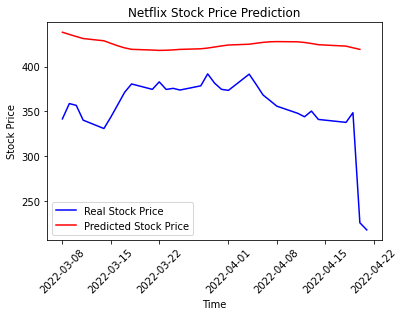

In [ ]:
# plot baseline and predictions
plt.plot(vis_df_a1['Date'], vis_df_a1['Actual'], color = 'blue', label = 'Real Stock Price')
plt.plot(vis_df_a1['Date'], vis_df_a1['Predicted'], color = 'red', label = 'Predicted Stock Price')

plt.title('Netflix Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.xticks(rotation=45)
plt.legend()
plt.show()

## Experiment A.2

### Create the model

In [ ]:
model = models.Sequential()
model.add(LSTM(30, input_shape=(30, 1), return_sequences=True)) 
model.add(Dropout(0.3))
model.add(LSTM(60, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(60))
model.add(Dropout(0.3))
model.add(Dense(1, activation="relu", name="output_layer"))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 30, 30)            3840      
                                                                 
 dropout_2 (Dropout)         (None, 30, 30)            0         
                                                                 
 lstm_3 (LSTM)               (None, 30, 60)            21840     
                                                                 
 dropout_3 (Dropout)         (None, 30, 60)            0         
                                                                 
 lstm_4 (LSTM)               (None, 60)                29040     
                                                                 
 dropout_4 (Dropout)         (None, 60)                0         
                                                                 
 output_layer (Dense)        (None, 1)                

In [ ]:
model.compile(loss='mean_squared_error',optimizer='adam',metrics=['mae'])

In [ ]:
experiment = "ExperimentA2"
callbacks = [EarlyStopping(monitor='val_mae', patience=3)
            ,ModelCheckpoint("/content/drive/My Drive/Colab Notebooks/MSDS498/LSTM_Models/"+experiment+".h5"
            ,save_best_only=True)]

In [ ]:
%%time
history = model.fit(X_train, y_train,
                    batch_size=16,
                    epochs=50,
                    validation_data=(X_val, y_val),
                    callbacks=callbacks)

Epoch 1/50
21/21 [==============================] - 5s 59ms/step - loss: 0.0654 - mae: 0.2117 - val_loss: 0.0185 - val_mae: 0.1170
Epoch 2/50
21/21 [==============================] - 0s 9ms/step - loss: 0.0105 - mae: 0.0808 - val_loss: 0.0198 - val_mae: 0.1217
Epoch 3/50
21/21 [==============================] - 0s 10ms/step - loss: 0.0094 - mae: 0.0769 - val_loss: 0.0206 - val_mae: 0.1241
Epoch 4/50
21/21 [==============================] - 0s 12ms/step - loss: 0.0091 - mae: 0.0748 - val_loss: 0.0175 - val_mae: 0.1144
Epoch 5/50
21/21 [==============================] - 0s 12ms/step - loss: 0.0081 - mae: 0.0729 - val_loss: 0.0166 - val_mae: 0.1112
Epoch 6/50
21/21 [==============================] - 0s 9ms/step - loss: 0.0074 - mae: 0.0694 - val_loss: 0.0181 - val_mae: 0.1166
Epoch 7/50
21/21 [==============================] - 0s 12ms/step - loss: 0.0067 - mae: 0.0675 - val_loss: 0.0129 - val_mae: 0.0967
Epoch 8/50
21/21 [==============================] - 0s 9ms/step - loss: 0.0074 - mae:

In [ ]:
experiment = "ExperimentA2"
model = tf.keras.models.load_model('/content/drive/My Drive/Colab Notebooks/MSDS498/LSTM_Models/'+experiment+'.h5')

In [ ]:
loss, mae = model.evaluate(X_test, y_test)
print('test set mae: ', mae)

1/1 [==============================] - 1s 942ms/step - loss: 0.0303 - mae: 0.1612
test set mae:  0.1612475961446762


### Plot performance

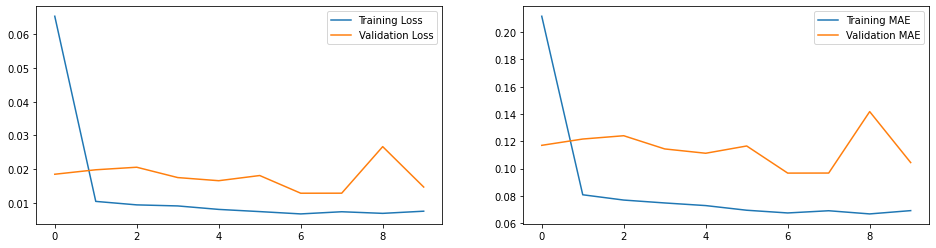

In [ ]:
plot_graphs()

In [ ]:
test_predict=model.predict(X_test)
test_predict=close_scaler.inverse_transform(test_predict)

vis = close_scaler.inverse_transform(data)
vis = vis[train_size+val_size+time_step:len(data)]

In [ ]:
df1 = df_stock.index.values
df1 = df1[train_size+val_size+time_step:]

In [ ]:
a = pd.DataFrame(df1, columns = ['Date'])
b = pd.DataFrame(vis, columns = ['Actual'])
c = pd.DataFrame(test_predict, columns = ['Predicted'])

vis_df_a2 = pd.concat([a,b,c], axis=1)

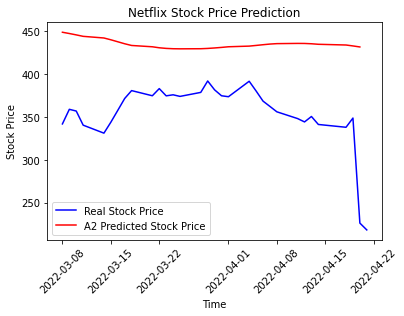

In [ ]:
# plot baseline and predictions
plt.plot(vis_df_a2['Date'], vis_df_a2['Actual'], color = 'blue', label = 'Real Stock Price')
plt.plot(vis_df_a2['Date'], vis_df_a2['Predicted'], color = 'red', label = 'A2 Predicted Stock Price')

plt.title('Netflix Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.xticks(rotation=45)
plt.legend()
plt.show()

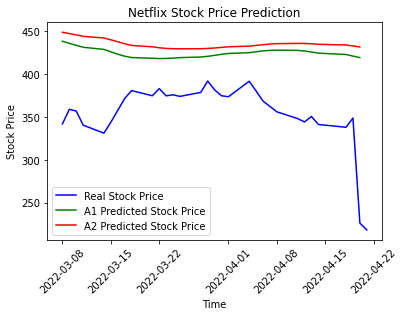

In [ ]:
# plot baseline and predictions
plt.plot(vis_df_a2['Date'], vis_df_a2['Actual'], color = 'blue', label = 'Real Stock Price')
plt.plot(vis_df_a1['Date'], vis_df_a1['Predicted'], color = 'green', label = 'A1 Predicted Stock Price')
plt.plot(vis_df_a2['Date'], vis_df_a2['Predicted'], color = 'red', label = 'A2 Predicted Stock Price')

plt.title('Netflix Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.xticks(rotation=45)
plt.legend()
plt.show()

## Experiment A.3

### Create the model

In [ ]:
model = models.Sequential()
model.add(Bidirectional(LSTM(30, return_sequences=True), input_shape=(30,1)))
model.add(Dropout(0.5))
model.add(LSTM(30))
model.add(Dropout(0.5))
model.add(Dense(1, activation="relu", name="output_layer"))

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 30, 60)           7680      
 l)                                                              
                                                                 
 dropout_5 (Dropout)         (None, 30, 60)            0         
                                                                 
 lstm_6 (LSTM)               (None, 30)                10920     
                                                                 
 dropout_6 (Dropout)         (None, 30)                0         
                                                                 
 output_layer (Dense)        (None, 1)                 31        
                                                                 
Total params: 18,631
Trainable params: 18,631
Non-trainable params: 0
__________________________________________________

In [ ]:
model.compile(loss='mean_squared_error',optimizer='adam',metrics=['mae'])

In [ ]:
experiment = "ExperimentA3"
callbacks = [EarlyStopping(monitor='val_mae', patience=3)
            ,ModelCheckpoint("/content/drive/My Drive/Colab Notebooks/MSDS498/LSTM_Models/"+experiment+".h5"
            ,save_best_only=True)]

In [ ]:
%%time
history = model.fit(X_train, y_train,
                    batch_size=16,
                    epochs=50,
                    validation_data=(X_val, y_val),
                    callbacks=callbacks)

Epoch 1/50
21/21 [==============================] - 6s 60ms/step - loss: 0.0601 - mae: 0.1989 - val_loss: 0.0432 - val_mae: 0.1934
Epoch 2/50
21/21 [==============================] - 0s 12ms/step - loss: 0.0286 - mae: 0.1341 - val_loss: 0.0210 - val_mae: 0.1262
Epoch 3/50
21/21 [==============================] - 0s 12ms/step - loss: 0.0216 - mae: 0.1182 - val_loss: 0.0099 - val_mae: 0.0854
Epoch 4/50
21/21 [==============================] - 0s 9ms/step - loss: 0.0196 - mae: 0.1105 - val_loss: 0.0129 - val_mae: 0.0980
Epoch 5/50
21/21 [==============================] - 0s 9ms/step - loss: 0.0176 - mae: 0.1048 - val_loss: 0.0116 - val_mae: 0.0930
Epoch 6/50
21/21 [==============================] - 0s 10ms/step - loss: 0.0176 - mae: 0.1052 - val_loss: 0.0214 - val_mae: 0.1279
CPU times: user 6.61 s, sys: 275 ms, total: 6.89 s
Wall time: 6.8 s


In [ ]:
experiment = "ExperimentA3"
model = tf.keras.models.load_model('/content/drive/My Drive/Colab Notebooks/MSDS498/LSTM_Models/'+experiment+'.h5')

In [ ]:
loss, mae = model.evaluate(X_test, y_test)
print('test set mae: ', mae)

1/1 [==============================] - 1s 1s/step - loss: 0.0135 - mae: 0.0988
test set mae:  0.09877363592386246


### Plot performance

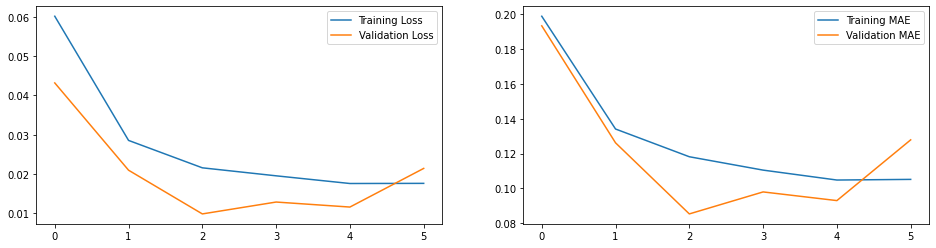

In [ ]:
plot_graphs()

In [ ]:
test_predict=model.predict(X_test)
test_predict=close_scaler.inverse_transform(test_predict)

vis = close_scaler.inverse_transform(data)
vis = vis[train_size+val_size+time_step:len(data)]

In [ ]:
df1 = df_stock.index.values
df1 = df1[train_size+val_size+time_step:]

In [ ]:
a = pd.DataFrame(df1, columns = ['Date'])
b = pd.DataFrame(vis, columns = ['Actual'])
c = pd.DataFrame(test_predict, columns = ['Predicted'])

vis_df_a3 = pd.concat([a,b,c], axis=1)

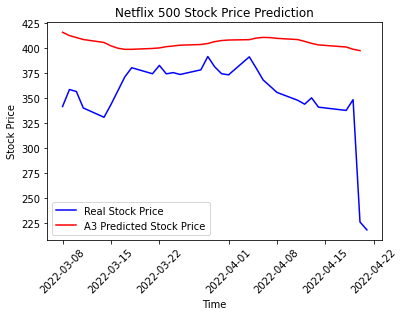

In [ ]:
# plot baseline and predictions
plt.plot(vis_df_a3['Date'], vis_df_a3['Actual'], color = 'blue', label = 'Real Stock Price')
plt.plot(vis_df_a3['Date'], vis_df_a3['Predicted'], color = 'red', label = 'A3 Predicted Stock Price')

plt.title('Netflix 500 Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.xticks(rotation=45)
plt.legend()
plt.show()

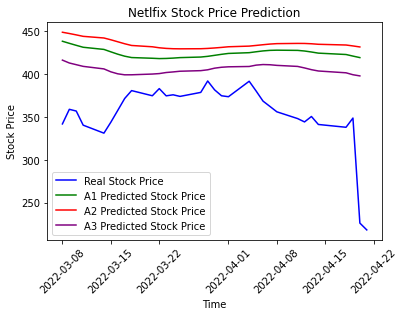

In [ ]:
# plot baseline and predictions
plt.plot(vis_df_a2['Date'], vis_df_a2['Actual'], color = 'blue', label = 'Real Stock Price')
plt.plot(vis_df_a1['Date'], vis_df_a1['Predicted'], color = 'green', label = 'A1 Predicted Stock Price')
plt.plot(vis_df_a2['Date'], vis_df_a2['Predicted'], color = 'red', label = 'A2 Predicted Stock Price')
plt.plot(vis_df_a3['Date'], vis_df_a3['Predicted'], color = 'purple', label = 'A3 Predicted Stock Price')

plt.title('Netlfix Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.xticks(rotation=45)
plt.legend()
plt.show()

#Experiment B: Input - Closing Price, Time step - 15


## Preprocess Data

In [ ]:
#reshape into X=t,t+1,...,t+14 and Y=t+15 -- 15 time steps to use as input variables to predict the next time period
time_step = 15
X_train, y_train = create_dataset(train_data, time_step)
X_val, y_val = create_dataset(val_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [ ]:
#reshape input to be [samples, time steps, features] -- only one feature, closing price
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

print("training set: ", X_train.shape)
print("validation set: ", X_val.shape)
print("test set: ", X_test.shape)

training set:  (337, 15, 1)
validation set:  (74, 15, 1)
test set:  (46, 15, 1)


## Experiment B.1

### Create the model

In [ ]:
model = models.Sequential()
model.add(LSTM(30, input_shape=(15, 1), return_sequences=True)) 
model.add(Dropout(0.3))
model.add(LSTM(30))
model.add(Dropout(0.3))
model.add(Dense(1, activation="relu", name="output_layer"))

In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 15, 30)            3840      
                                                                 
 dropout_14 (Dropout)        (None, 15, 30)            0         
                                                                 
 lstm_15 (LSTM)              (None, 30)                7320      
                                                                 
 dropout_15 (Dropout)        (None, 30)                0         
                                                                 
 output_layer (Dense)        (None, 1)                 31        
                                                                 
Total params: 11,191
Trainable params: 11,191
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss='mean_squared_error',optimizer='adam',metrics=['mae'])

In [ ]:
experiment = "ExperimentB1"
callbacks = [EarlyStopping(monitor='val_mae', patience=3)
            ,ModelCheckpoint("/content/drive/My Drive/Colab Notebooks/MSDS498/LSTM_Models/"+experiment+".h5"
            ,save_best_only=True)]

In [ ]:
%%time
history = model.fit(X_train, y_train,
                    batch_size=16,
                    epochs=50,
                    validation_data=(X_val, y_val),
                    callbacks=callbacks)

Epoch 1/50
22/22 [==============================] - 4s 47ms/step - loss: 0.1582 - mae: 0.3438 - val_loss: 0.0135 - val_mae: 0.0929
Epoch 2/50
22/22 [==============================] - 0s 7ms/step - loss: 0.0195 - mae: 0.1115 - val_loss: 0.0291 - val_mae: 0.1539
Epoch 3/50
22/22 [==============================] - 0s 7ms/step - loss: 0.0166 - mae: 0.1019 - val_loss: 0.0217 - val_mae: 0.1313
Epoch 4/50
22/22 [==============================] - 0s 8ms/step - loss: 0.0144 - mae: 0.0932 - val_loss: 0.0158 - val_mae: 0.1121
CPU times: user 4.24 s, sys: 150 ms, total: 4.39 s
Wall time: 4.26 s


In [ ]:
experiment = "ExperimentB1"
model = tf.keras.models.load_model('/content/drive/My Drive/Colab Notebooks/MSDS498/LSTM_Models/'+experiment+'.h5')

In [ ]:
loss, mae = model.evaluate(X_test, y_test)
print('test set mae: ', mae)

2/2 [==============================] - 1s 8ms/step - loss: 0.0550 - mae: 0.2277
test set mae:  0.22769585251808167


### Plot performance

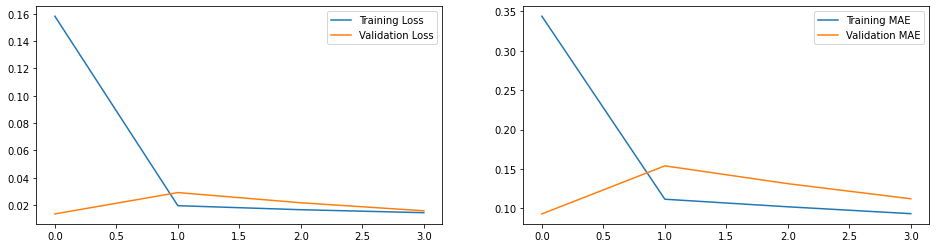

In [ ]:
plot_graphs()

In [ ]:
test_predict = model.predict(X_test)
test_predict = close_scaler.inverse_transform(test_predict)

In [ ]:
vis = close_scaler.inverse_transform(data)
vis = vis[train_size+val_size+time_step:len(data)]

In [ ]:
df1 = df_stock.index.values
df1 = df1[train_size+val_size+time_step:]

In [ ]:
a = pd.DataFrame(df1, columns = ['Date'])
b = pd.DataFrame(vis, columns = ['Actual'])
c = pd.DataFrame(test_predict, columns = ['Predicted'])

vis_df_b1 = pd.concat([a,b,c], axis=1)

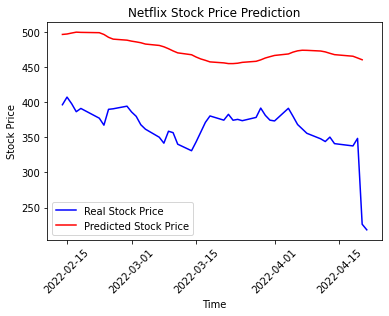

In [ ]:
# plot baseline and predictions
plt.plot(vis_df_b1['Date'], vis_df_b1['Actual'], color = 'blue', label = 'Real Stock Price')
plt.plot(vis_df_b1['Date'], vis_df_b1['Predicted'], color = 'red', label = 'Predicted Stock Price')

plt.title('Netflix Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.xticks(rotation=45)
plt.legend()
plt.show()

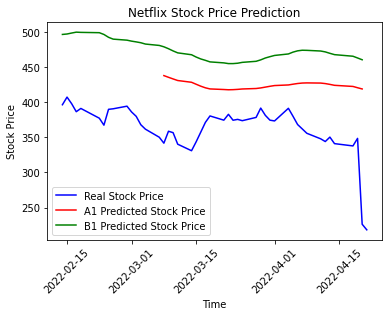

In [ ]:
plt.plot(vis_df_b1['Date'], vis_df_b1['Actual'], color = 'blue', label = 'Real Stock Price')
plt.plot(vis_df_a1['Date'], vis_df_a1['Predicted'], color = 'red', label = 'A1 Predicted Stock Price')
plt.plot(vis_df_b1['Date'], vis_df_b1['Predicted'], color = 'green', label = 'B1 Predicted Stock Price')

plt.title('Netflix Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.xticks(rotation=45)
plt.legend()
plt.show()

## Experiment B.2

### Create the model

In [ ]:
model = models.Sequential()
model.add(LSTM(30, input_shape=(15, 1), return_sequences=True)) 
model.add(Dropout(0.3))
model.add(LSTM(60, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(60))
model.add(Dropout(0.3))
model.add(Dense(1, activation="relu", name="output_layer"))

In [ ]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_19 (LSTM)              (None, 15, 30)            3840      
                                                                 
 dropout_19 (Dropout)        (None, 15, 30)            0         
                                                                 
 lstm_20 (LSTM)              (None, 15, 60)            21840     
                                                                 
 dropout_20 (Dropout)        (None, 15, 60)            0         
                                                                 
 lstm_21 (LSTM)              (None, 60)                29040     
                                                                 
 dropout_21 (Dropout)        (None, 60)                0         
                                                                 
 output_layer (Dense)        (None, 1)                

In [ ]:
model.compile(loss='mean_squared_error',optimizer='adam',metrics=['mae'])

In [ ]:
experiment = "ExperimentB2"
callbacks = [EarlyStopping(monitor='val_mae', patience=3)
            ,ModelCheckpoint("/content/drive/My Drive/Colab Notebooks/MSDS458/Final Project/Models/"+experiment+".h5"
            ,save_best_only=True)]

In [ ]:
%%time
history = model.fit(X_train, y_train,
                    batch_size=16,
                    epochs=50,
                    validation_data=(X_val, y_val),
                    callbacks=callbacks)

Epoch 1/50
22/22 [==============================] - 6s 85ms/step - loss: 0.0650 - mae: 0.1993 - val_loss: 0.0295 - val_mae: 0.1542
Epoch 2/50
22/22 [==============================] - 0s 11ms/step - loss: 0.0103 - mae: 0.0802 - val_loss: 0.0175 - val_mae: 0.1178
Epoch 3/50
22/22 [==============================] - 0s 10ms/step - loss: 0.0104 - mae: 0.0801 - val_loss: 0.0138 - val_mae: 0.1042
Epoch 4/50
22/22 [==============================] - 0s 9ms/step - loss: 0.0075 - mae: 0.0671 - val_loss: 0.0163 - val_mae: 0.1137
Epoch 5/50
22/22 [==============================] - 0s 9ms/step - loss: 0.0084 - mae: 0.0747 - val_loss: 0.0177 - val_mae: 0.1184
Epoch 6/50
22/22 [==============================] - 0s 11ms/step - loss: 0.0075 - mae: 0.0683 - val_loss: 0.0077 - val_mae: 0.0759
Epoch 7/50
22/22 [==============================] - 0s 8ms/step - loss: 0.0080 - mae: 0.0693 - val_loss: 0.0175 - val_mae: 0.1177
Epoch 8/50
22/22 [==============================] - 0s 9ms/step - loss: 0.0076 - mae: 

In [ ]:
experiment = "ExperimentB2"
model = tf.keras.models.load_model('/content/drive/My Drive/Colab Notebooks/MSDS458/Final Project/Models/'+experiment+'.h5')

In [ ]:
loss, mae = model.evaluate(X_test, y_test)
print('test set mae: ', mae)

2/2 [==============================] - 1s 9ms/step - loss: 0.0226 - mae: 0.1392
test set mae:  0.13918718695640564


### Plot performance

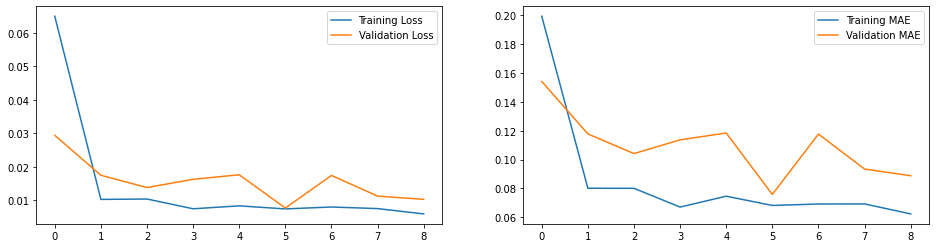

In [ ]:
plot_graphs()

In [ ]:
test_predict = model.predict(X_test)
test_predict = close_scaler.inverse_transform(test_predict)

In [ ]:
vis = close_scaler.inverse_transform(data)
vis = vis[train_size+val_size+time_step:len(data)]

In [ ]:
df1 = df_stock.index.values
df1 = df1[train_size+val_size+time_step:]

In [ ]:
a = pd.DataFrame(df1, columns = ['Date'])
b = pd.DataFrame(vis, columns = ['Actual'])
c = pd.DataFrame(test_predict, columns = ['Predicted'])

vis_df_b2 = pd.concat([a,b,c], axis=1)

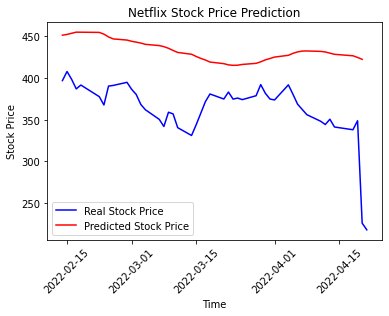

In [ ]:
# plot baseline and predictions
plt.plot(vis_df_b2['Date'], vis_df_b2['Actual'], color = 'blue', label = 'Real Stock Price')
plt.plot(vis_df_b2['Date'], vis_df_b2['Predicted'], color = 'red', label = 'Predicted Stock Price')

plt.title('Netflix Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.xticks(rotation=45)
plt.legend()
plt.show()

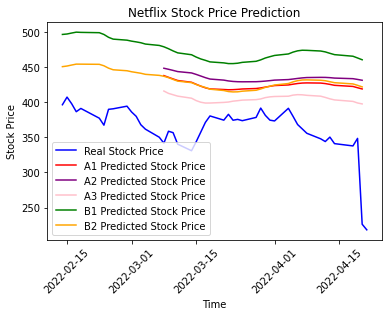

In [ ]:
plt.plot(vis_df_b2['Date'], vis_df_b2['Actual'], color = 'blue', label = 'Real Stock Price')
plt.plot(vis_df_a1['Date'], vis_df_a1['Predicted'], color = 'red', label = 'A1 Predicted Stock Price')
plt.plot(vis_df_a2['Date'], vis_df_a2['Predicted'], color = 'purple', label = 'A2 Predicted Stock Price')
plt.plot(vis_df_a3['Date'], vis_df_a3['Predicted'], color = 'pink', label = 'A3 Predicted Stock Price')
plt.plot(vis_df_b1['Date'], vis_df_b1['Predicted'], color = 'green', label = 'B1 Predicted Stock Price')
plt.plot(vis_df_b2['Date'], vis_df_b2['Predicted'], color = 'orange', label = 'B2 Predicted Stock Price')

plt.title('Netflix Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.xticks(rotation=45)
plt.legend()
plt.show()

## Experiment B.3

### Create the model

In [ ]:
model = models.Sequential()
model.add(Bidirectional(LSTM(30, return_sequences=True), input_shape=(15,1)))
model.add(Dropout(0.5))
model.add(LSTM(30))
model.add(Dropout(0.5))
model.add(Dense(1, activation="relu", name="output_layer"))

In [ ]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_4 (Bidirectio  (None, 15, 60)           7680      
 nal)                                                            
                                                                 
 dropout_22 (Dropout)        (None, 15, 60)            0         
                                                                 
 lstm_23 (LSTM)              (None, 30)                10920     
                                                                 
 dropout_23 (Dropout)        (None, 30)                0         
                                                                 
 output_layer (Dense)        (None, 1)                 31        
                                                                 
Total params: 18,631
Trainable params: 18,631
Non-trainable params: 0
__________________________________________________

In [ ]:
model.compile(loss='mean_squared_error',optimizer='adam',metrics=['mae'])

In [ ]:
experiment = "ExperimentB3"
callbacks = [EarlyStopping(monitor='val_mae', patience=3)
            ,ModelCheckpoint("/content/drive/My Drive/Colab Notebooks/MSDS458/Final Project/Models/"+experiment+".h5"
            ,save_best_only=True)]

In [ ]:
%%time
history = model.fit(X_train, y_train,
                    batch_size=16,
                    epochs=50,
                    validation_data=(X_val, y_val),
                    callbacks=callbacks)

Epoch 1/50
22/22 [==============================] - 7s 94ms/step - loss: 0.0663 - mae: 0.2045 - val_loss: 0.0399 - val_mae: 0.1881
Epoch 2/50
22/22 [==============================] - 0s 11ms/step - loss: 0.0245 - mae: 0.1263 - val_loss: 0.0149 - val_mae: 0.1080
Epoch 3/50
22/22 [==============================] - 0s 11ms/step - loss: 0.0201 - mae: 0.1142 - val_loss: 0.0095 - val_mae: 0.0862
Epoch 4/50
22/22 [==============================] - 0s 9ms/step - loss: 0.0196 - mae: 0.1131 - val_loss: 0.0143 - val_mae: 0.1060
Epoch 5/50
22/22 [==============================] - 0s 9ms/step - loss: 0.0208 - mae: 0.1159 - val_loss: 0.0158 - val_mae: 0.1114
Epoch 6/50
22/22 [==============================] - 0s 9ms/step - loss: 0.0174 - mae: 0.1051 - val_loss: 0.0216 - val_mae: 0.1322
CPU times: user 7.5 s, sys: 258 ms, total: 7.76 s
Wall time: 8.47 s


In [ ]:
experiment = "ExperimentB3"
model = tf.keras.models.load_model('/content/drive/My Drive/Colab Notebooks/MSDS458/Final Project/Models/'+experiment+'.h5')

In [ ]:
loss, mae = model.evaluate(X_test, y_test)
print('test set mae: ', mae)

2/2 [==============================] - 2s 23ms/step - loss: 0.0121 - mae: 0.0979
test set mae:  0.0978582501411438


### Plot performance

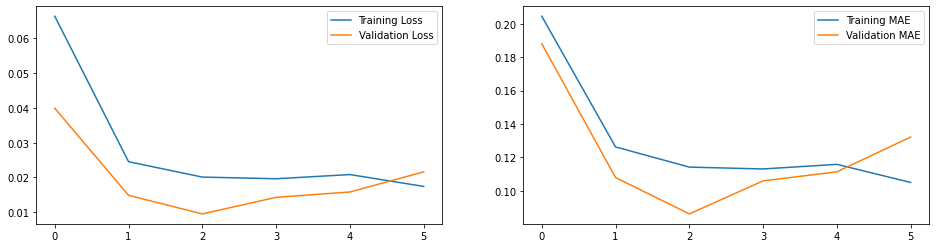

In [ ]:
plot_graphs()

In [ ]:
test_predict = model.predict(X_test)
test_predict = close_scaler.inverse_transform(test_predict)

In [ ]:
vis = close_scaler.inverse_transform(data)
vis = vis[train_size+val_size+time_step:len(data)]

In [ ]:
df1 = df_stock.index.values
df1 = df1[train_size+val_size+time_step:]

In [ ]:
a = pd.DataFrame(df1, columns = ['Date'])
b = pd.DataFrame(vis, columns = ['Actual'])
c = pd.DataFrame(test_predict, columns = ['Predicted'])

vis_df_b3 = pd.concat([a,b,c], axis=1)

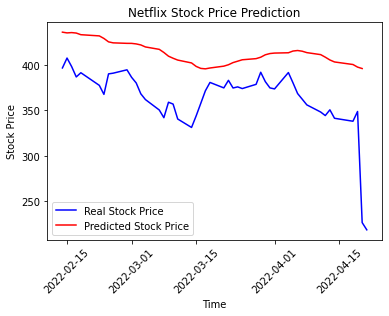

In [ ]:
# plot baseline and predictions
plt.plot(vis_df_b3['Date'], vis_df_b3['Actual'], color = 'blue', label = 'Real Stock Price')
plt.plot(vis_df_b3['Date'], vis_df_b3['Predicted'], color = 'red', label = 'Predicted Stock Price')

plt.title('Netflix Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.xticks(rotation=45)
plt.legend()
plt.show()

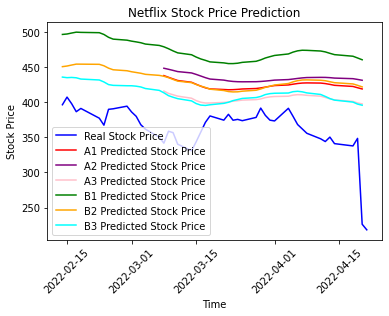

In [ ]:
plt.plot(vis_df_b3['Date'], vis_df_b3['Actual'], color = 'blue', label = 'Real Stock Price')
plt.plot(vis_df_a1['Date'], vis_df_a1['Predicted'], color = 'red', label = 'A1 Predicted Stock Price')
plt.plot(vis_df_a2['Date'], vis_df_a2['Predicted'], color = 'purple', label = 'A2 Predicted Stock Price')
plt.plot(vis_df_a3['Date'], vis_df_a3['Predicted'], color = 'pink', label = 'A3 Predicted Stock Price')
plt.plot(vis_df_b1['Date'], vis_df_b1['Predicted'], color = 'green', label = 'B1 Predicted Stock Price')
plt.plot(vis_df_b2['Date'], vis_df_b2['Predicted'], color = 'orange', label = 'B2 Predicted Stock Price')
plt.plot(vis_df_b3['Date'], vis_df_b3['Predicted'], color = 'cyan', label = 'B3 Predicted Stock Price')

plt.title('Netflix Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.xticks(rotation=45)
plt.legend()
plt.show()

#Experiment C: Input - Closing Price, Time step - 10

### Preprocess Data

In [ ]:
time_step = 10
X_train, y_train = create_dataset(train_data, time_step)
X_val, y_val = create_dataset(val_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [ ]:
#reshape input to be [samples, time steps, features] -- only one feature, closing price
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

print("training set: ", X_train.shape)
print("validation set: ", X_val.shape)
print("test set: ", X_test.shape)

training set:  (342, 10, 1)
validation set:  (79, 10, 1)
test set:  (51, 10, 1)


## Experiment C.1

### Create the model

In [ ]:
model = models.Sequential()
model.add(LSTM(30, input_shape=(10, 1), return_sequences=True)) 
model.add(Dropout(0.3))
model.add(LSTM(30))
model.add(Dropout(0.3))
model.add(Dense(1, activation="relu", name="output_layer"))

In [ ]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_24 (LSTM)              (None, 10, 30)            3840      
                                                                 
 dropout_24 (Dropout)        (None, 10, 30)            0         
                                                                 
 lstm_25 (LSTM)              (None, 30)                7320      
                                                                 
 dropout_25 (Dropout)        (None, 30)                0         
                                                                 
 output_layer (Dense)        (None, 1)                 31        
                                                                 
Total params: 11,191
Trainable params: 11,191
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss='mean_squared_error',optimizer='adam',metrics=['mae'])

In [ ]:
experiment = "ExperimentC1"
callbacks = [EarlyStopping(monitor='val_mae', patience=3)
            ,ModelCheckpoint("/content/drive/My Drive/Colab Notebooks/MSDS498/LSTM_Models/"+experiment+".h5"
            ,save_best_only=True)]

In [ ]:
%%time
history = model.fit(X_train, y_train,
                    batch_size=16,
                    epochs=50,
                    validation_data=(X_val, y_val),
                    callbacks=callbacks)

Epoch 1/50
22/22 [==============================] - 5s 78ms/step - loss: 0.1464 - mae: 0.3248 - val_loss: 0.0112 - val_mae: 0.0871
Epoch 2/50
22/22 [==============================] - 0s 14ms/step - loss: 0.0178 - mae: 0.1036 - val_loss: 0.0203 - val_mae: 0.1279
Epoch 3/50
22/22 [==============================] - 0s 13ms/step - loss: 0.0123 - mae: 0.0881 - val_loss: 0.0186 - val_mae: 0.1217
Epoch 4/50
22/22 [==============================] - 0s 8ms/step - loss: 0.0121 - mae: 0.0876 - val_loss: 0.0127 - val_mae: 0.1004
CPU times: user 5.43 s, sys: 122 ms, total: 5.56 s
Wall time: 6.06 s


In [ ]:
experiment = "ExperimentC1"
model = tf.keras.models.load_model('/content/drive/My Drive/Colab Notebooks/MSDS498/LSTM_Models/'+experiment+'.h5')

In [ ]:
loss, mae = model.evaluate(X_test, y_test)
print('test set mae: ', mae)

2/2 [==============================] - 1s 8ms/step - loss: 0.0351 - mae: 0.1802
test set mae:  0.18016523122787476


### Plot performance

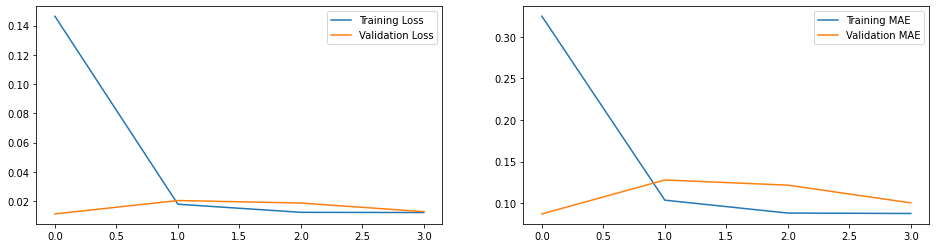

In [ ]:
plot_graphs()

In [ ]:
test_predict = model.predict(X_test)
test_predict = close_scaler.inverse_transform(test_predict)

In [ ]:
vis = close_scaler.inverse_transform(data)
vis = vis[train_size+val_size+time_step:len(data)]

In [ ]:
df1 = df_stock.index.values
df1 = df1[train_size+val_size+time_step:]

In [ ]:
a = pd.DataFrame(df1, columns = ['Date'])
b = pd.DataFrame(vis, columns = ['Actual'])
c = pd.DataFrame(test_predict, columns = ['Predicted'])

vis_df_c1 = pd.concat([a,b,c], axis=1)

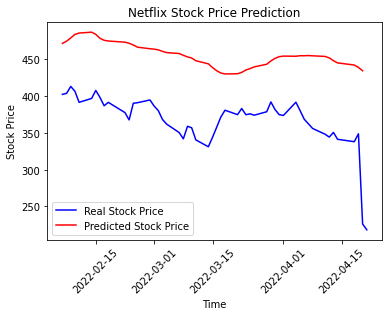

In [ ]:
# plot baseline and predictions
plt.plot(vis_df_c1['Date'], vis_df_c1['Actual'], color = 'blue', label = 'Real Stock Price')
plt.plot(vis_df_c1['Date'], vis_df_c1['Predicted'], color = 'red', label = 'Predicted Stock Price')

plt.title('Netflix Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.xticks(rotation=45)
plt.legend()
plt.show()

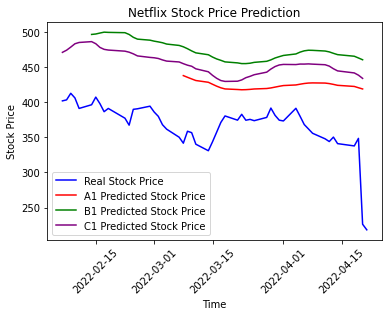

In [ ]:
plt.plot(vis_df_c1['Date'], vis_df_c1['Actual'], color = 'blue', label = 'Real Stock Price')
plt.plot(vis_df_a1['Date'], vis_df_a1['Predicted'], color = 'red', label = 'A1 Predicted Stock Price')
plt.plot(vis_df_b1['Date'], vis_df_b1['Predicted'], color = 'green', label = 'B1 Predicted Stock Price')
plt.plot(vis_df_c1['Date'], vis_df_c1['Predicted'], color = 'purple', label = 'C1 Predicted Stock Price')

plt.title('Netflix Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.xticks(rotation=45)
plt.legend()
plt.show()

## Experiment C.2

### Create the model

In [ ]:
model = models.Sequential()
model.add(Bidirectional(LSTM(30, return_sequences=True), input_shape=(10,1)))
model.add(Dropout(0.5))
model.add(LSTM(30))
model.add(Dropout(0.5))
model.add(Dense(1, activation="relu", name="output_layer"))

In [ ]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_5 (Bidirectio  (None, 10, 60)           7680      
 nal)                                                            
                                                                 
 dropout_26 (Dropout)        (None, 10, 60)            0         
                                                                 
 lstm_27 (LSTM)              (None, 30)                10920     
                                                                 
 dropout_27 (Dropout)        (None, 30)                0         
                                                                 
 output_layer (Dense)        (None, 1)                 31        
                                                                 
Total params: 18,631
Trainable params: 18,631
Non-trainable params: 0
_________________________________________________

In [ ]:
model.compile(loss='mean_squared_error',optimizer='adam',metrics=['mae'])

In [ ]:
experiment = "ExperimentC2"
callbacks = [EarlyStopping(monitor='val_mae', patience=3)
            ,ModelCheckpoint("/content/drive/My Drive/Colab Notebooks/MSDS498/LSTM_Models/"+experiment+".h5"
            ,save_best_only=True)]

In [ ]:
%%time
history = model.fit(X_train, y_train,
                    batch_size=16,
                    epochs=50,
                    validation_data=(X_val, y_val),
                    callbacks=callbacks)

Epoch 1/50
22/22 [==============================] - 6s 58ms/step - loss: 0.0928 - mae: 0.2520 - val_loss: 0.0098 - val_mae: 0.0879
Epoch 2/50
22/22 [==============================] - 0s 10ms/step - loss: 0.0248 - mae: 0.1285 - val_loss: 0.0038 - val_mae: 0.0522
Epoch 3/50
22/22 [==============================] - 0s 8ms/step - loss: 0.0228 - mae: 0.1212 - val_loss: 0.0121 - val_mae: 0.0979
Epoch 4/50
22/22 [==============================] - 0s 8ms/step - loss: 0.0192 - mae: 0.1082 - val_loss: 0.0173 - val_mae: 0.1179
Epoch 5/50
22/22 [==============================] - 0s 9ms/step - loss: 0.0182 - mae: 0.1058 - val_loss: 0.0215 - val_mae: 0.1331
CPU times: user 6.6 s, sys: 227 ms, total: 6.83 s
Wall time: 6.46 s


In [ ]:
experiment = "ExperimentC2"
model = tf.keras.models.load_model('/content/drive/My Drive/Colab Notebooks/MSDS498/LSTM_Models/'+experiment+'.h5')

In [ ]:
loss, mae = model.evaluate(X_test, y_test)
print('test set mae: ', mae)

2/2 [==============================] - 1s 11ms/step - loss: 0.0163 - mae: 0.1183
test set mae:  0.11830107122659683


### Plot performance

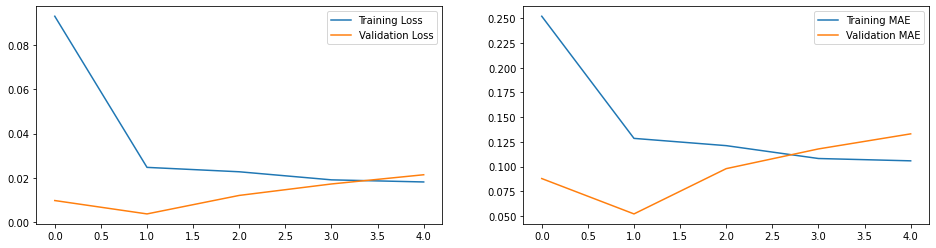

In [ ]:
plot_graphs()

In [ ]:
test_predict = model.predict(X_test)
test_predict = close_scaler.inverse_transform(test_predict)

In [ ]:
vis = close_scaler.inverse_transform(data)
vis = vis[train_size+val_size+time_step:len(data)]

In [ ]:
df1 = df_stock.index.values
df1 = df1[train_size+val_size+time_step:]

In [ ]:
a = pd.DataFrame(df1, columns = ['Date'])
b = pd.DataFrame(vis, columns = ['Actual'])
c = pd.DataFrame(test_predict, columns = ['Predicted'])

vis_df_c2 = pd.concat([a,b,c], axis=1)

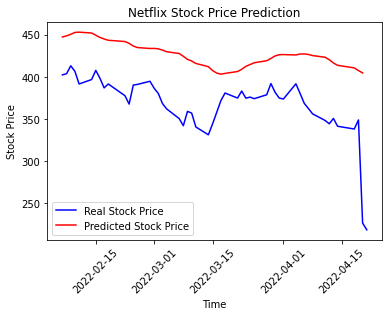

In [ ]:
# plot baseline and predictions
plt.plot(vis_df_c2['Date'], vis_df_c2['Actual'], color = 'blue', label = 'Real Stock Price')
plt.plot(vis_df_c2['Date'], vis_df_c2['Predicted'], color = 'red', label = 'Predicted Stock Price')

plt.title('Netflix Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.xticks(rotation=45)
plt.legend()
plt.show()

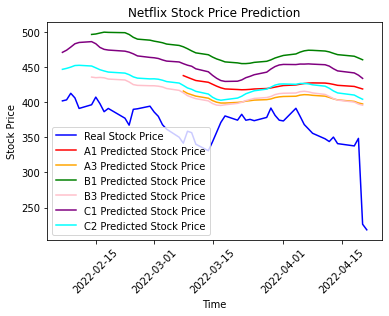

In [ ]:
plt.plot(vis_df_c2['Date'], vis_df_c2['Actual'], color = 'blue', label = 'Real Stock Price')
plt.plot(vis_df_a1['Date'], vis_df_a1['Predicted'], color = 'red', label = 'A1 Predicted Stock Price')
plt.plot(vis_df_a3['Date'], vis_df_a3['Predicted'], color = 'orange', label = 'A3 Predicted Stock Price')
plt.plot(vis_df_b1['Date'], vis_df_b1['Predicted'], color = 'green', label = 'B1 Predicted Stock Price')
plt.plot(vis_df_b3['Date'], vis_df_b3['Predicted'], color = 'pink', label = 'B3 Predicted Stock Price')
plt.plot(vis_df_c1['Date'], vis_df_c1['Predicted'], color = 'purple', label = 'C1 Predicted Stock Price')
plt.plot(vis_df_c2['Date'], vis_df_c2['Predicted'], color = 'cyan', label = 'C2 Predicted Stock Price')

plt.title('Netflix Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.xticks(rotation=45)
plt.legend()
plt.show()

#Experiment D: Input - Closing Price, Time step - 5

### Preprocess Data

In [ ]:
time_step = 5
X_train, y_train = create_dataset(train_data, time_step)
X_val, y_val = create_dataset(val_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [ ]:
#reshape input to be [samples, time steps, features] -- only one feature, closing price
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

print("training set: ", X_train.shape)
print("validation set: ", X_val.shape)
print("test set: ", X_test.shape)

training set:  (347, 5, 1)
validation set:  (84, 5, 1)
test set:  (56, 5, 1)


## Experiment D.1

### Create the model

In [ ]:
model = models.Sequential()
model.add(LSTM(30, input_shape=(5, 1), return_sequences=True)) 
model.add(Dropout(0.3))
model.add(LSTM(30))
model.add(Dropout(0.3))
model.add(Dense(1, activation="relu", name="output_layer"))

In [ ]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_28 (LSTM)              (None, 5, 30)             3840      
                                                                 
 dropout_28 (Dropout)        (None, 5, 30)             0         
                                                                 
 lstm_29 (LSTM)              (None, 30)                7320      
                                                                 
 dropout_29 (Dropout)        (None, 30)                0         
                                                                 
 output_layer (Dense)        (None, 1)                 31        
                                                                 
Total params: 11,191
Trainable params: 11,191
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss='mean_squared_error',optimizer='adam',metrics=['mae'])

In [ ]:
experiment = "ExperimentD1"
callbacks = [EarlyStopping(monitor='val_mae', patience=3)
            ,ModelCheckpoint("/content/drive/My Drive/Colab Notebooks/MSDS498/LSTM_Models/"+experiment+".h5"
            ,save_best_only=True)]

In [ ]:
%%time
history = model.fit(X_train, y_train,
                    batch_size=16,
                    epochs=50,
                    validation_data=(X_val, y_val),
                    callbacks=callbacks)

Epoch 1/50
22/22 [==============================] - 4s 41ms/step - loss: 0.1774 - mae: 0.3866 - val_loss: 0.0306 - val_mae: 0.1655
Epoch 2/50
22/22 [==============================] - 0s 8ms/step - loss: 0.0176 - mae: 0.1070 - val_loss: 0.0265 - val_mae: 0.1522
Epoch 3/50
22/22 [==============================] - 0s 8ms/step - loss: 0.0124 - mae: 0.0894 - val_loss: 0.0106 - val_mae: 0.0915
Epoch 4/50
22/22 [==============================] - 0s 6ms/step - loss: 0.0099 - mae: 0.0771 - val_loss: 0.0119 - val_mae: 0.0970
Epoch 5/50
22/22 [==============================] - 0s 7ms/step - loss: 0.0105 - mae: 0.0833 - val_loss: 0.0107 - val_mae: 0.0917
Epoch 6/50
22/22 [==============================] - 0s 7ms/step - loss: 0.0105 - mae: 0.0817 - val_loss: 0.0133 - val_mae: 0.1033
CPU times: user 4.53 s, sys: 144 ms, total: 4.68 s
Wall time: 4.45 s


In [ ]:
experiment = "ExperimentD1"
model = tf.keras.models.load_model('/content/drive/My Drive/Colab Notebooks/MSDS498/LSTM_Models/'+experiment+'.h5')

In [ ]:
loss, mae = model.evaluate(X_test, y_test)
print('test set mae: ', mae)

2/2 [==============================] - 1s 8ms/step - loss: 0.0154 - mae: 0.1135
test set mae:  0.11347001791000366


### Plot performance

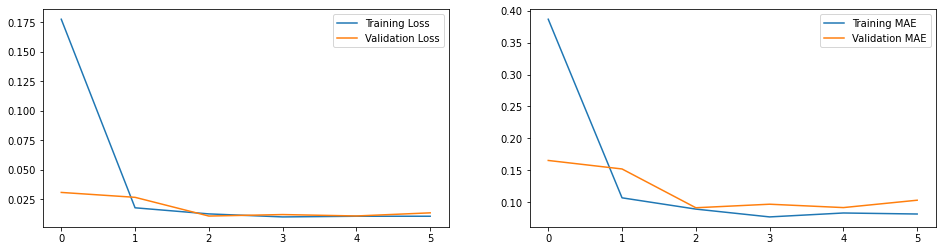

In [ ]:
plot_graphs()

In [ ]:
test_predict = model.predict(X_test)
test_predict = close_scaler.inverse_transform(test_predict)

In [ ]:
vis = close_scaler.inverse_transform(data)
vis = vis[train_size+val_size+time_step:len(data)]

In [ ]:
df1 = df_stock.index.values
df1 = df1[train_size+val_size+time_step:]

In [ ]:
a = pd.DataFrame(df1, columns = ['Date'])
b = pd.DataFrame(vis, columns = ['Actual'])
c = pd.DataFrame(test_predict, columns = ['Predicted'])

vis_df_d1 = pd.concat([a,b,c], axis=1)

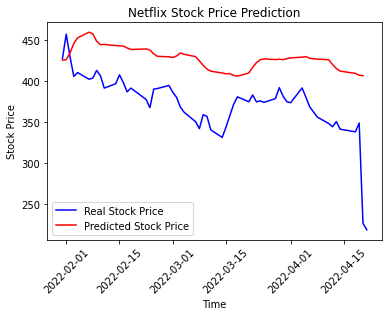

In [ ]:
# plot baseline and predictions
plt.plot(vis_df_d1['Date'], vis_df_d1['Actual'], color = 'blue', label = 'Real Stock Price')
plt.plot(vis_df_d1['Date'], vis_df_d1['Predicted'], color = 'red', label = 'Predicted Stock Price')

plt.title('Netflix Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.xticks(rotation=45)
plt.legend()
plt.show()

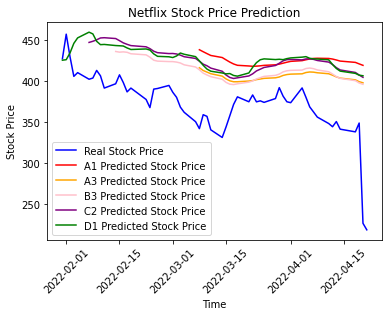

In [ ]:
plt.plot(vis_df_d1['Date'], vis_df_d1['Actual'], color = 'blue', label = 'Real Stock Price')
plt.plot(vis_df_a1['Date'], vis_df_a1['Predicted'], color = 'red', label = 'A1 Predicted Stock Price')
plt.plot(vis_df_a3['Date'], vis_df_a3['Predicted'], color = 'orange', label = 'A3 Predicted Stock Price')
#plt.plot(vis_df_b1['Date'], vis_df_b1['Predicted'], color = 'green', label = 'B1 Predicted Stock Price')
plt.plot(vis_df_b3['Date'], vis_df_b3['Predicted'], color = 'pink', label = 'B3 Predicted Stock Price')
#plt.plot(vis_df_c1['Date'], vis_df_c1['Predicted'], color = 'purple', label = 'C1 Predicted Stock Price')
plt.plot(vis_df_c2['Date'], vis_df_c2['Predicted'], color = 'purple', label = 'C2 Predicted Stock Price')
plt.plot(vis_df_d1['Date'], vis_df_d1['Predicted'], color = 'green', label = 'D1 Predicted Stock Price')

plt.title('Netflix Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.xticks(rotation=45)
plt.legend()
plt.show()

## Experiment D.2

### Create the model

In [ ]:
model = models.Sequential()
model.add(Bidirectional(LSTM(30, return_sequences=True), input_shape=(5,1)))
model.add(Dropout(0.5))
model.add(LSTM(30))
model.add(Dropout(0.5))
model.add(Dense(1, activation="relu", name="output_layer"))

In [ ]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_6 (Bidirectio  (None, 5, 60)            7680      
 nal)                                                            
                                                                 
 dropout_30 (Dropout)        (None, 5, 60)             0         
                                                                 
 lstm_31 (LSTM)              (None, 30)                10920     
                                                                 
 dropout_31 (Dropout)        (None, 30)                0         
                                                                 
 output_layer (Dense)        (None, 1)                 31        
                                                                 
Total params: 18,631
Trainable params: 18,631
Non-trainable params: 0
_________________________________________________

In [ ]:
model.compile(loss='mean_squared_error',optimizer='adam',metrics=['mae'])

In [ ]:
experiment = "ExperimentD2"
callbacks = [EarlyStopping(monitor='val_mae', patience=3)
            ,ModelCheckpoint("/content/drive/My Drive/Colab Notebooks/MSDS498/LSTM_Models/"+experiment+".h5"
            ,save_best_only=True)]

In [ ]:
%%time
history = model.fit(X_train, y_train,
                    batch_size=16,
                    epochs=50,
                    validation_data=(X_val, y_val),
                    callbacks=callbacks)

Epoch 1/50
22/22 [==============================] - 5s 59ms/step - loss: 0.1599 - mae: 0.3467 - val_loss: 0.0029 - val_mae: 0.0428
Epoch 2/50
22/22 [==============================] - 0s 8ms/step - loss: 0.0281 - mae: 0.1334 - val_loss: 0.0278 - val_mae: 0.1581
Epoch 3/50
22/22 [==============================] - 0s 9ms/step - loss: 0.0200 - mae: 0.1135 - val_loss: 0.0149 - val_mae: 0.1111
Epoch 4/50
22/22 [==============================] - 0s 9ms/step - loss: 0.0153 - mae: 0.0970 - val_loss: 0.0157 - val_mae: 0.1143
CPU times: user 5.92 s, sys: 194 ms, total: 6.11 s
Wall time: 5.82 s


In [ ]:
experiment = "ExperimentD2"
model = tf.keras.models.load_model('/content/drive/My Drive/Colab Notebooks/MSDS498/LSTM_Models/'+experiment+'.h5')

In [ ]:
loss, mae = model.evaluate(X_test, y_test)
print('test set mae: ', mae)

2/2 [==============================] - 1s 9ms/step - loss: 0.0250 - mae: 0.1500
test set mae:  0.14998647570610046


### Plot performance

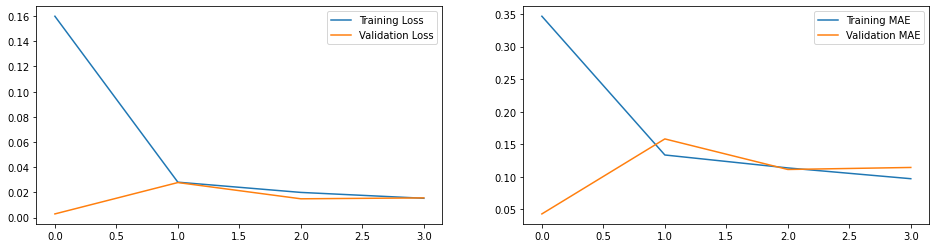

In [ ]:
plot_graphs()

In [ ]:
test_predict=model.predict(X_test)
test_predict=close_scaler.inverse_transform(test_predict)

vis = close_scaler.inverse_transform(data)
vis = vis[train_size+val_size+time_step:len(data)]

In [ ]:
df1 = df_stock.index.values
df1 = df1[train_size+val_size+time_step:]

In [ ]:
a = pd.DataFrame(df1, columns = ['Date'])
b = pd.DataFrame(vis, columns = ['Actual'])
c = pd.DataFrame(test_predict, columns = ['Predicted'])

vis_df_d2 = pd.concat([a,b,c], axis=1)

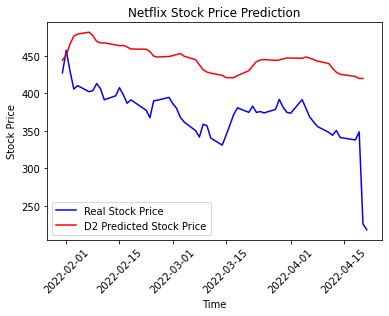

In [ ]:
# plot baseline and predictions
plt.plot(vis_df_d2['Date'], vis_df_d2['Actual'], color = 'blue', label = 'Real Stock Price')
plt.plot(vis_df_d2['Date'], vis_df_d2['Predicted'], color = 'red', label = 'D2 Predicted Stock Price')

plt.title('Netflix Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.xticks(rotation=45)
plt.legend()
plt.show()

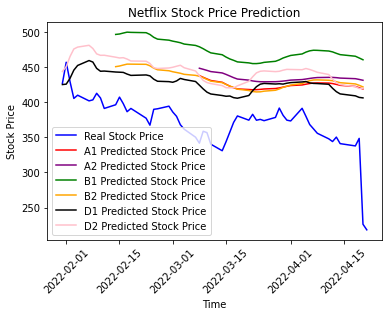

In [ ]:
# plot baseline and predictions
plt.plot(vis_df_d2['Date'], vis_df_d2['Actual'], color = 'blue', label = 'Real Stock Price')
plt.plot(vis_df_a1['Date'], vis_df_a1['Predicted'], color = 'red', label = 'A1 Predicted Stock Price')
plt.plot(vis_df_a2['Date'], vis_df_a2['Predicted'], color = 'purple', label = 'A2 Predicted Stock Price')
plt.plot(vis_df_b1['Date'], vis_df_b1['Predicted'], color = 'green', label = 'B1 Predicted Stock Price')
plt.plot(vis_df_b2['Date'], vis_df_b2['Predicted'], color = 'orange', label = 'B2 Predicted Stock Price')
plt.plot(vis_df_d1['Date'], vis_df_d1['Predicted'], color = 'black', label = 'D1 Predicted Stock Price')
plt.plot(vis_df_d2['Date'], vis_df_d2['Predicted'], color = 'pink', label = 'D2 Predicted Stock Price')

plt.title('Netflix Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.xticks(rotation=45)
plt.legend()
plt.show()

# Experiment E: Input - Closing Price and Finbert Labels, Time Step - 5

Multivariate Forecasting

### Load Data

In [ ]:
df_tweet_finbert = df_tweet_avg_sentiment[['finbert']]
df_tweet_finbert.head()

,finbert
date,
2020-04-22,0.859364
2020-04-23,0.898470
2020-04-24,0.914110
2020-04-25,0.873518
2020-04-26,0.906810


In [ ]:
df_tweet_finbert.describe()

,finbert
count,616.000000
mean,0.893828
std,0.047881
min,0.692130
25%,0.868831
50%,0.895697
75%,0.922657
max,1.112880


In [ ]:
merge_df = pd.merge(df_stock, df_tweet_finbert, left_index=True, right_index=True)
merge_df.head()

,Close,finbert
2020-04-22,421.420013,0.859364
2020-04-23,426.700012,0.898470
2020-04-24,424.989990,0.914110
2020-04-27,421.380005,0.899761
2020-04-28,403.829987,0.953719


In [ ]:
merge_df.isnull().sum()

Close      0
finbert    0
dtype: int64

### Explore Data

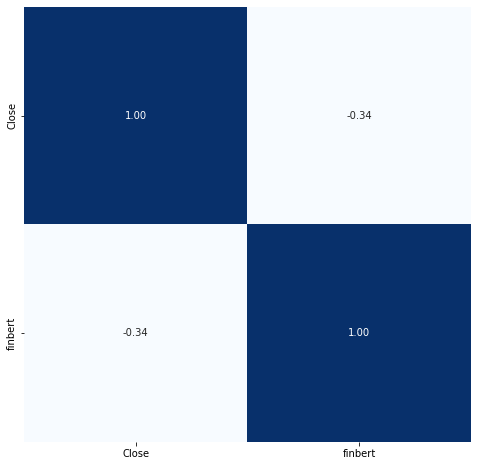

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(merge_df.corr(), annot=True, fmt='.2f', cbar=False, ax=ax, cmap='Blues')

It seems like the closing stock price and finbert sentiment have weak correlation.

In [ ]:
merge_df = merge_df.reset_index()
merge_df.rename(columns={'index': 'date'}, inplace=True)
merge_df.head()

,date,Close,finbert
0,2020-04-22,421.420013,0.859364
1,2020-04-23,426.700012,0.898470
2,2020-04-24,424.989990,0.914110
3,2020-04-27,421.380005,0.899761
4,2020-04-28,403.829987,0.953719


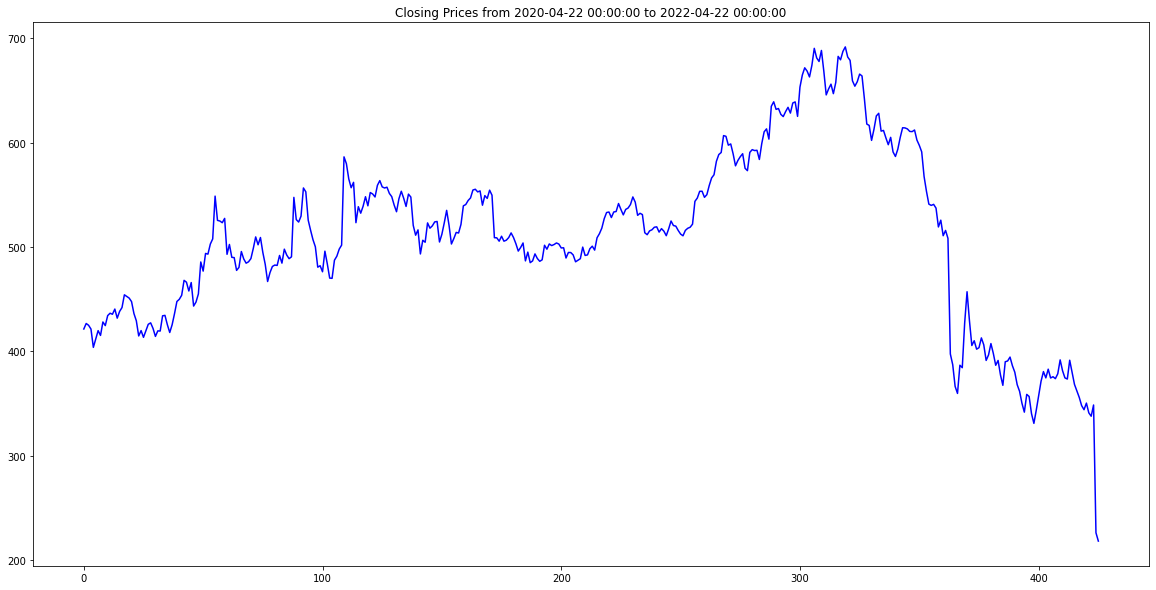

In [ ]:
start_date = datetime.datetime(2020, 4, 22)
end_date = datetime.datetime(2022, 4, 22)

plt.figure(figsize = (20,10))
plt.title('Closing Prices from {} to {}'.format(start_date, end_date))
plt.plot(merge_df.index, merge_df['Close'], color = 'blue')
plt.show()

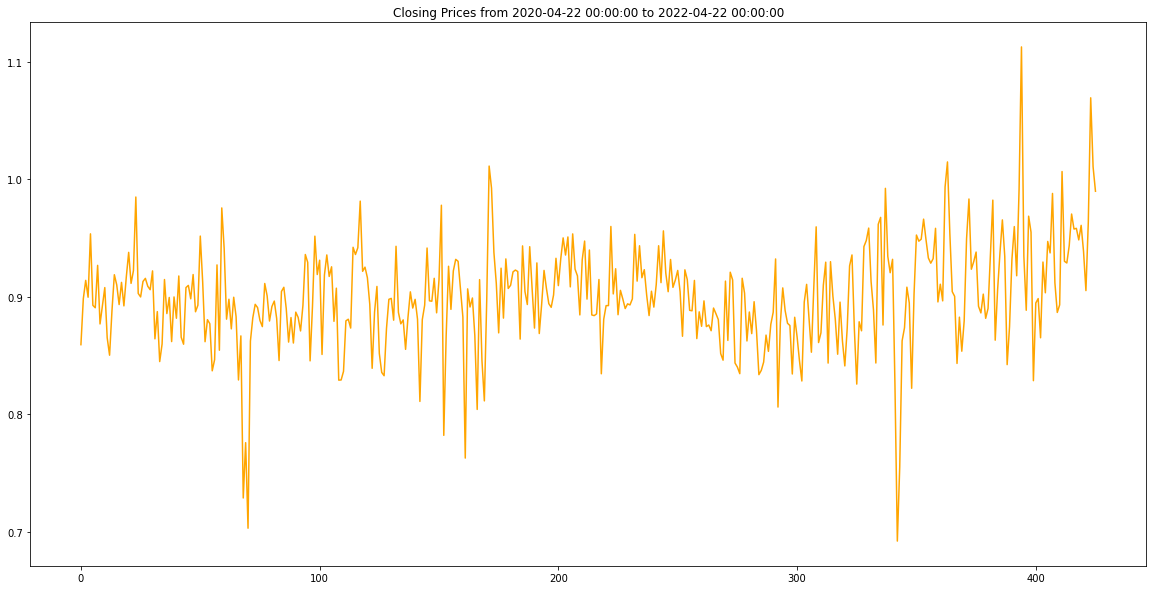

In [ ]:
start_date = datetime.datetime(2020, 4, 22)
end_date = datetime.datetime(2022, 4, 22)

plt.figure(figsize = (20,10))
plt.title('Closing Prices from {} to {}'.format(start_date, end_date))
plt.plot(merge_df.index, merge_df['finbert'], color = 'orange')
plt.show()

### Preprocess Data

In [ ]:
merge_df = merge_df.set_index(keys='date')
merge_df.head()

,Close,finbert
date,,
2020-04-22,421.420013,0.859364
2020-04-23,426.700012,0.898470
2020-04-24,424.989990,0.914110
2020-04-27,421.380005,0.899761
2020-04-28,403.829987,0.953719


In [ ]:
close_scaler = MinMaxScaler(feature_range=(0,1))
sentiment_scaler = MinMaxScaler(feature_range=(0,1))
merge_data = merge_df.copy()
merge_data["Close"] = close_scaler.fit_transform(np.array(merge_df["Close"]).reshape(-1, 1))
merge_data["finbert"] = sentiment_scaler.fit_transform(np.array(merge_df["finbert"]).reshape(-1, 1))

In [ ]:
merge_data.shape

(426, 2)

In [ ]:
# split into train, val, and test sets
train_size = int(len(merge_data) * 0.70)
val_size = int(0.18 * len(merge_data))
test_size = len(merge_data) - train_size - val_size

In [ ]:
train_size, val_size, test_size

(298, 76, 52)

In [ ]:
train_data,val_data, test_data = merge_data[0:train_size], merge_data[train_size:train_size+val_size], merge_data[train_size+val_size:len(merge_data)]

In [ ]:
train_data.shape, val_data.shape, test_data.shape

((298, 2), (76, 2), (52, 2))

In [ ]:
# choose a number of time steps
time_step = 5
input1 = "Close"
input2 = "finbert"

in_seq1, in_seq2, out_seq = input_sequence(train_data, input1, input2)
# horizontally stack columns
dataset = np.hstack((in_seq1, in_seq2, out_seq))
# convert into input/output
X_train, y_train = split_sequences(dataset, time_step)
print(X_train.shape, X_train.shape)
for i in range(len(X_train)):
  print(X_train[i], y_train[i])
  break

(293, 5, 2) (293, 5, 2)
[[0.429 0.397]
 [0.44  0.49 ]
 [0.437 0.528]
 [0.429 0.493]
 [0.392 0.622]] 0.4090438949213534


In [ ]:
in_seq1, in_seq2, out_seq = input_sequence(val_data, input1, input2)
# horizontally stack columns
dataset = np.hstack((in_seq1, in_seq2, out_seq))
# convert into input/output
X_val, y_val = split_sequences(dataset, time_step)

In [ ]:
in_seq1, in_seq2, out_seq = input_sequence(test_data, input1, input2)
# horizontally stack columns
dataset = np.hstack((in_seq1, in_seq2, out_seq))
# convert into input/output
X_test, y_test = split_sequences(dataset, time_step)

In [ ]:
X_train.shape, X_val.shape, X_test.shape

((293, 5, 2), (71, 5, 2), (47, 5, 2))

## Experiment E.1

### Create the model

In [ ]:
model = models.Sequential()
model.add(LSTM(30, input_shape=(5, 2), return_sequences=True)) 
model.add(Dropout(0.3))
model.add(LSTM(30))
model.add(Dropout(0.3))
model.add(Dense(1, activation="relu", name="output_layer"))

In [ ]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_34 (LSTM)              (None, 5, 30)             3960      
                                                                 
 dropout_34 (Dropout)        (None, 5, 30)             0         
                                                                 
 lstm_35 (LSTM)              (None, 30)                7320      
                                                                 
 dropout_35 (Dropout)        (None, 30)                0         
                                                                 
 output_layer (Dense)        (None, 1)                 31        
                                                                 
Total params: 11,311
Trainable params: 11,311
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss='mean_squared_error',optimizer='adam',metrics=['mae'])

In [ ]:
experiment = "ExperimentE1"
callbacks = [EarlyStopping(monitor='val_mae', patience=3)
            ,ModelCheckpoint("/content/drive/My Drive/Colab Notebooks/MSDS498/LSTM_Models/"+experiment+".h5"
            ,save_best_only=True)]

In [ ]:
%%time
history = model.fit(X_train, y_train,
                    batch_size=16,
                    epochs=50,
                    validation_data=(X_val, y_val),
                    callbacks=callbacks)

Epoch 1/50
19/19 [==============================] - 4s 75ms/step - loss: 0.2447 - mae: 0.4664 - val_loss: 0.1090 - val_mae: 0.3028
Epoch 2/50
19/19 [==============================] - 0s 8ms/step - loss: 0.0276 - mae: 0.1353 - val_loss: 0.0264 - val_mae: 0.1413
Epoch 3/50
19/19 [==============================] - 0s 6ms/step - loss: 0.0192 - mae: 0.1084 - val_loss: 0.0337 - val_mae: 0.1612
Epoch 4/50
19/19 [==============================] - 0s 7ms/step - loss: 0.0134 - mae: 0.0910 - val_loss: 0.0266 - val_mae: 0.1425
Epoch 5/50
19/19 [==============================] - 0s 9ms/step - loss: 0.0135 - mae: 0.0908 - val_loss: 0.0219 - val_mae: 0.1279
Epoch 6/50
19/19 [==============================] - 0s 7ms/step - loss: 0.0139 - mae: 0.0927 - val_loss: 0.0237 - val_mae: 0.1337
Epoch 7/50
19/19 [==============================] - 0s 9ms/step - loss: 0.0115 - mae: 0.0849 - val_loss: 0.0157 - val_mae: 0.1057
Epoch 8/50
19/19 [==============================] - 0s 9ms/step - loss: 0.0114 - mae: 0.0

In [ ]:
experiment = "ExperimentE1"
model = tf.keras.models.load_model("/content/drive/My Drive/Colab Notebooks/MSDS498/LSTM_Models/"+experiment+".h5")

In [ ]:
loss, mae = model.evaluate(X_test, y_test)
print('test set mae: ', mae)

2/2 [==============================] - 1s 7ms/step - loss: 0.0083 - mae: 0.0707
test set mae:  0.07066022604703903


### Plot performance

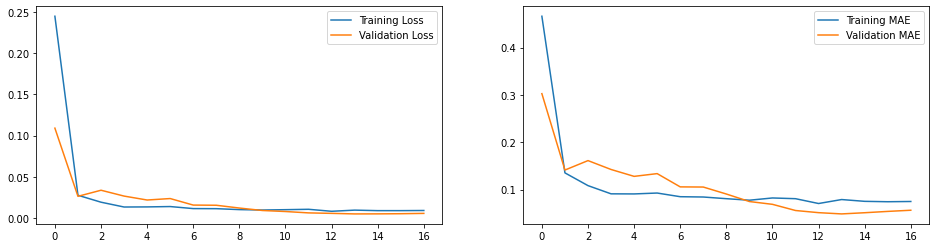

In [ ]:
plot_graphs()

In [ ]:
test_predict = model.predict(X_test)
test_predict = close_scaler.inverse_transform(test_predict)

In [ ]:
merge_data_vis = merge_data.copy()
close_data = np.array(merge_data_vis['Close']).reshape(-1,1)
vis = close_scaler.inverse_transform(close_data)
vis = vis[train_size+val_size+time_step:len(close_data)]

In [ ]:
merge_data_vis = merge_data_vis.index.values
merge_data_vis = merge_data_vis[train_size+val_size+time_step:]

In [ ]:
a = pd.DataFrame(merge_data_vis)
b = pd.DataFrame(vis, columns = ['Actual'])
c = pd.DataFrame(test_predict, columns = ['Predicted'])
vis_df_e1 = pd.concat([a,b,c], axis=1)#.sort_values(by='date')
vis_df_e1.head()

,0,Actual,Predicted
0,2022-02-14,396.570007,422.533722
1,2022-02-15,407.459991,424.111664
2,2022-02-16,398.079987,426.490875
3,2022-02-17,386.670013,423.039276
4,2022-02-18,391.290009,418.603516


In [ ]:
vis_df_e1.rename(columns={ vis_df_e1.columns[0]: "date" }, inplace = True)

In [ ]:
vis_df_e1.head()

,date,Actual,Predicted
0,2022-02-14,396.570007,422.533722
1,2022-02-15,407.459991,424.111664
2,2022-02-16,398.079987,426.490875
3,2022-02-17,386.670013,423.039276
4,2022-02-18,391.290009,418.603516


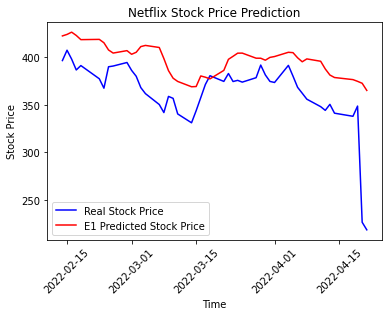

In [ ]:
# plot baseline and predictions
plt.plot(vis_df_e1['date'], vis_df_e1['Actual'], color = 'blue', label = 'Real Stock Price')
plt.plot(vis_df_e1['date'], vis_df_e1['Predicted'], color = 'red', label = 'E1 Predicted Stock Price')

plt.title('Netflix Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.xticks(rotation=45)
plt.legend()
plt.show()

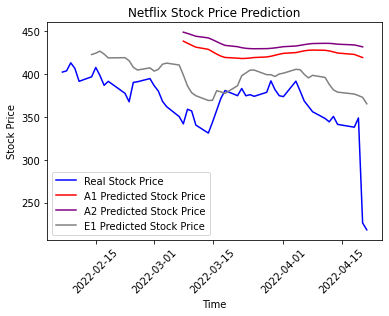

In [ ]:
# plot baseline and predictions
plt.plot(vis_df_c1['Date'], vis_df_c1['Actual'], color = 'blue', label = 'Real Stock Price')
#plt.plot(vis_df_c1['Date'], vis_df_c1['Predicted'], color = 'purple', label = 'C1 Predicted Stock Price')
plt.plot(vis_df_a1['Date'], vis_df_a1['Predicted'], color = 'red', label = 'A1 Predicted Stock Price')
plt.plot(vis_df_a2['Date'], vis_df_a2['Predicted'], color = 'purple', label = 'A2 Predicted Stock Price')
#plt.plot(vis_df_b1['Date'], vis_df_b1['Predicted'], color = 'green', label = 'B1 Predicted Stock Price')
#plt.plot(vis_df_b2['Date'], vis_df_b2['Predicted'], color = 'orange', label = 'B2 Predicted Stock Price')
#plt.plot(vis_df_d1['Date'], vis_df_d1['Predicted'], color = 'black', label = 'D1 Predicted Stock Price')
#plt.plot(vis_df_d2['Date'], vis_df_d2['Predicted'], color = 'pink', label = 'D2 Predicted Stock Price')
plt.plot(vis_df_e1['date'], vis_df_e1['Predicted'], color = 'gray', label = 'E1 Predicted Stock Price')

plt.title('Netflix Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.xticks(rotation=45)
plt.legend()
plt.show()

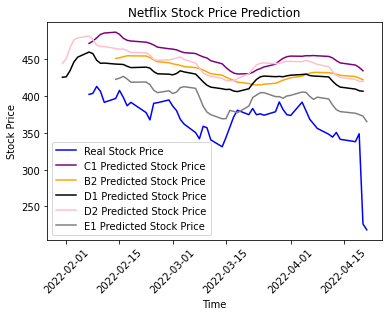

In [ ]:
# plot baseline and predictions
plt.plot(vis_df_c1['Date'], vis_df_c1['Actual'], color = 'blue', label = 'Real Stock Price')
plt.plot(vis_df_c1['Date'], vis_df_c1['Predicted'], color = 'purple', label = 'C1 Predicted Stock Price')
#plt.plot(vis_df_a1['Date'], vis_df_a1['Predicted'], color = 'red', label = 'A1 Predicted Stock Price')
#plt.plot(vis_df_a2['Date'], vis_df_a2['Predicted'], color = 'purple', label = 'A2 Predicted Stock Price')
#plt.plot(vis_df_b1['Date'], vis_df_b1['Predicted'], color = 'green', label = 'B1 Predicted Stock Price')
plt.plot(vis_df_b2['Date'], vis_df_b2['Predicted'], color = 'orange', label = 'B2 Predicted Stock Price')
plt.plot(vis_df_d1['Date'], vis_df_d1['Predicted'], color = 'black', label = 'D1 Predicted Stock Price')
plt.plot(vis_df_d2['Date'], vis_df_d2['Predicted'], color = 'pink', label = 'D2 Predicted Stock Price')
plt.plot(vis_df_e1['date'], vis_df_e1['Predicted'], color = 'gray', label = 'E1 Predicted Stock Price')

plt.title('Netflix Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.xticks(rotation=45)
plt.legend()
plt.show()

## Experiment E.2

### Create the model

In [ ]:
model = models.Sequential()
model.add(Bidirectional(LSTM(30, return_sequences=True), input_shape=(5,2)))
model.add(Dropout(0.5))
model.add(LSTM(30))
model.add(Dropout(0.5))
model.add(Dense(1, activation="relu", name="output_layer"))

In [ ]:
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_7 (Bidirectio  (None, 5, 60)            7920      
 nal)                                                            
                                                                 
 dropout_36 (Dropout)        (None, 5, 60)             0         
                                                                 
 lstm_37 (LSTM)              (None, 30)                10920     
                                                                 
 dropout_37 (Dropout)        (None, 30)                0         
                                                                 
 output_layer (Dense)        (None, 1)                 31        
                                                                 
Total params: 18,871
Trainable params: 18,871
Non-trainable params: 0
_________________________________________________

In [ ]:
model.compile(loss='mean_squared_error',optimizer='adam',metrics=['mae'])

In [ ]:
experiment = "ExperimentE2"
callbacks = [EarlyStopping(monitor='val_mae', patience=3)
            ,ModelCheckpoint("/content/drive/My Drive/Colab Notebooks/MSDS498/LSTM_Models/"+experiment+".h5"
            ,save_best_only=True)]

In [ ]:
%%time
history = model.fit(X_train, y_train,
                    batch_size=16,
                    epochs=50,
                    validation_data=(X_val, y_val),
                    callbacks=callbacks)

Epoch 1/50
19/19 [==============================] - 6s 67ms/step - loss: 0.1962 - mae: 0.4016 - val_loss: 0.0416 - val_mae: 0.1794
Epoch 2/50
19/19 [==============================] - 0s 11ms/step - loss: 0.0354 - mae: 0.1457 - val_loss: 0.0385 - val_mae: 0.1732
Epoch 3/50
19/19 [==============================] - 0s 11ms/step - loss: 0.0285 - mae: 0.1367 - val_loss: 0.0234 - val_mae: 0.1330
Epoch 4/50
19/19 [==============================] - 0s 8ms/step - loss: 0.0284 - mae: 0.1328 - val_loss: 0.0374 - val_mae: 0.1729
Epoch 5/50
19/19 [==============================] - 0s 12ms/step - loss: 0.0256 - mae: 0.1312 - val_loss: 0.0205 - val_mae: 0.1240
Epoch 6/50
19/19 [==============================] - 0s 11ms/step - loss: 0.0192 - mae: 0.1119 - val_loss: 0.0189 - val_mae: 0.1187
Epoch 7/50
19/19 [==============================] - 0s 11ms/step - loss: 0.0175 - mae: 0.1047 - val_loss: 0.0128 - val_mae: 0.0951
Epoch 8/50
19/19 [==============================] - 0s 9ms/step - loss: 0.0185 - mae

In [ ]:
experiment = "ExperimentE2"
model = tf.keras.models.load_model("/content/drive/My Drive/Colab Notebooks/MSDS498/LSTM_Models/"+experiment+".h5")

In [ ]:
loss, mae = model.evaluate(X_test, y_test)
print('test set mae: ', mae)

2/2 [==============================] - 1s 8ms/step - loss: 0.0033 - mae: 0.0363
test set mae:  0.0363202840089798


### Plot performance

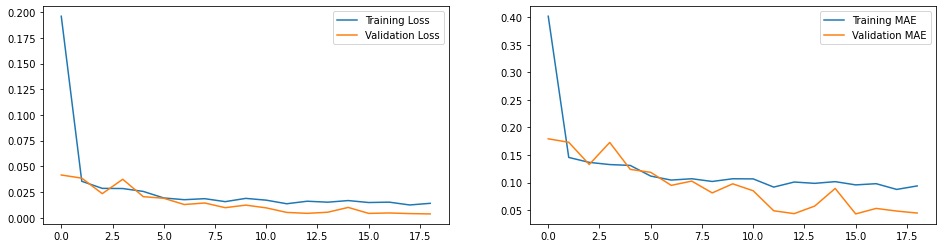

In [ ]:
plot_graphs()

In [ ]:
test_predict = model.predict(X_test)
test_predict = close_scaler.inverse_transform(test_predict)

In [ ]:
merge_data_vis = merge_data.copy()
close_data = np.array(merge_data_vis['Close']).reshape(-1,1)
vis = close_scaler.inverse_transform(close_data)
vis = vis[train_size+val_size+time_step:len(close_data)]

In [ ]:
merge_data_vis = merge_data_vis.index.values
merge_data_vis = merge_data_vis[train_size+val_size+time_step:]

In [ ]:
a = pd.DataFrame(merge_data_vis)
b = pd.DataFrame(vis, columns = ['Actual'])
c = pd.DataFrame(test_predict, columns = ['Predicted'])
vis_df_e2 = pd.concat([a,b,c], axis=1)

In [ ]:
vis_df_e2.rename(columns={ vis_df_e2.columns[0]: "date" }, inplace = True)

In [ ]:
vis_df_e2.head()

,date,Actual,Predicted
0,2022-02-14,396.570007,409.745300
1,2022-02-15,407.459991,410.936066
2,2022-02-16,398.079987,412.855652
3,2022-02-17,386.670013,406.406891
4,2022-02-18,391.290009,395.501740


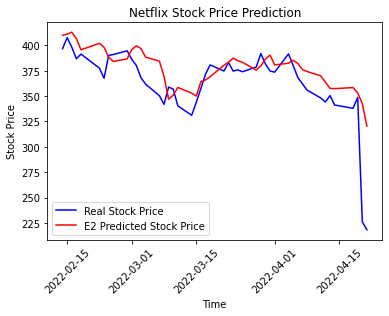

In [ ]:
# plot baseline and predictions
plt.plot(vis_df_e2['date'], vis_df_e2['Actual'], color = 'blue', label = 'Real Stock Price')
plt.plot(vis_df_e2['date'], vis_df_e2['Predicted'], color = 'red', label = 'E2 Predicted Stock Price')

plt.title('Netflix Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.xticks(rotation=45)
plt.legend()
plt.show()

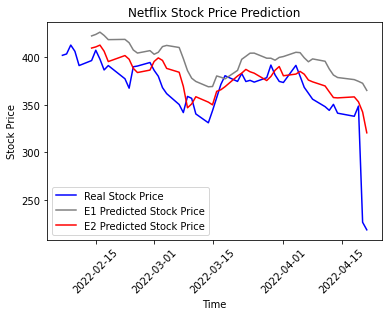

In [ ]:
# plot baseline and predictions
plt.plot(vis_df_c1['Date'], vis_df_c1['Actual'], color = 'blue', label = 'Real Stock Price')
plt.plot(vis_df_e1['date'], vis_df_e1['Predicted'], color = 'gray', label = 'E1 Predicted Stock Price')
plt.plot(vis_df_e2['date'], vis_df_e2['Predicted'], color = 'red', label = 'E2 Predicted Stock Price')

plt.title('Netflix Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.xticks(rotation=45)
plt.legend()
plt.show()

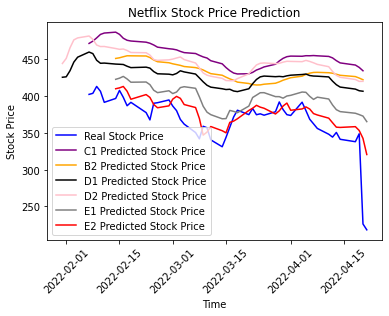

In [ ]:
# plot baseline and predictions
plt.plot(vis_df_c1['Date'], vis_df_c1['Actual'], color = 'blue', label = 'Real Stock Price')
plt.plot(vis_df_c1['Date'], vis_df_c1['Predicted'], color = 'purple', label = 'C1 Predicted Stock Price')
#plt.plot(vis_df_a1['Date'], vis_df_a1['Predicted'], color = 'red', label = 'A1 Predicted Stock Price')
#plt.plot(vis_df_a2['Date'], vis_df_a2['Predicted'], color = 'purple', label = 'A2 Predicted Stock Price')
#plt.plot(vis_df_b1['Date'], vis_df_b1['Predicted'], color = 'green', label = 'B1 Predicted Stock Price')
plt.plot(vis_df_b2['Date'], vis_df_b2['Predicted'], color = 'orange', label = 'B2 Predicted Stock Price')
plt.plot(vis_df_d1['Date'], vis_df_d1['Predicted'], color = 'black', label = 'D1 Predicted Stock Price')
plt.plot(vis_df_d2['Date'], vis_df_d2['Predicted'], color = 'pink', label = 'D2 Predicted Stock Price')
plt.plot(vis_df_e1['date'], vis_df_e1['Predicted'], color = 'gray', label = 'E1 Predicted Stock Price')
plt.plot(vis_df_e2['date'], vis_df_e2['Predicted'], color = 'red', label = 'E2 Predicted Stock Price')

plt.title('Netflix Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.xticks(rotation=45)
plt.legend()
plt.show()